## Flatten Model

### imports

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, log_loss
from sklearn.metrics import confusion_matrix
from scipy.stats import entropy
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from tqdm import tqdm
import time
from sklearn.base import BaseEstimator, TransformerMixin
from xgboost import XGBClassifier

import os, gc
os.environ["CUDA_VISIBLE_DEVICES"]="0,1"

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### train.csv

In [3]:
train_file_path = '/content/drive/My Drive/HMS/train.csv'

In [4]:
df = pd.read_csv(train_file_path)

In [5]:
df.shape

(106800, 15)

In [6]:
df.columns

Index(['eeg_id', 'eeg_sub_id', 'eeg_label_offset_seconds', 'spectrogram_id',
       'spectrogram_sub_id', 'spectrogram_label_offset_seconds', 'label_id',
       'patient_id', 'expert_consensus', 'seizure_vote', 'lpd_vote',
       'gpd_vote', 'lrda_vote', 'grda_vote', 'other_vote'],
      dtype='object')

In [7]:
df['expert_consensus'].value_counts()

Seizure    20933
GRDA       18861
Other      18808
GPD        16702
LRDA       16640
LPD        14856
Name: expert_consensus, dtype: int64

In [8]:
filtered_df = df[df['spectrogram_sub_id'] == 0]
value_counts = filtered_df['expert_consensus'].value_counts()
print(value_counts)

Other      4699
Seizure    2045
GRDA       1422
LPD        1284
GPD        1025
LRDA        663
Name: expert_consensus, dtype: int64


### train.pqt

In [9]:
train_pqt_file_path = '/content/drive/My Drive/HMS/train.pqt'

In [10]:
df_pqt = pd.read_parquet(train_pqt_file_path, engine='pyarrow')

In [11]:
df_pqt.shape

(17089, 412)

In [12]:
le = LabelEncoder()

df['target_encoded'] = le.fit_transform(df['expert_consensus']) 

### specs.npy

In [13]:
def load_spectrograms(path, read_spec_files=False):

    if read_spec_files:
        spectrograms = {}
        for i,f in enumerate(files):
            if i%100==0: print(i,', ',end='')
            tmp = pd.read_parquet(f'{path}//{f}')
            name = int(f.split('.')[0])
            spectrograms[name] = tmp.iloc[:,1:].values
    else:
        spectrograms = np.load(f"{path}", allow_pickle=True).item()
    return spectrograms

In [14]:
def get_column_names():
    columns = []
    regions = ['LL_', 'RL_', 'LP_', 'RP_']
    increments = [
        0.59, 0.78, 0.98, 1.17, 1.37, 1.56, 1.76, 1.95, 2.15, 2.34,
        2.54, 2.73, 2.93, 3.13, 3.32, 3.52, 3.71, 3.91, 4.1, 4.3,
        4.49, 4.69, 4.88, 5.08, 5.27, 5.47, 5.66, 5.86, 6.05, 6.25,
        6.45, 6.64, 6.84, 7.03, 7.23, 7.42, 7.62, 7.81, 8.01, 8.2,
        8.4, 8.59, 8.79, 8.98, 9.18, 9.38, 9.57, 9.77, 9.96, 10.16,
        10.35, 10.55, 10.74, 10.94, 11.13, 11.33, 11.52, 11.72, 11.91,
        12.11, 12.3, 12.5, 12.7, 12.89, 13.09, 13.28, 13.48, 13.67,
        13.87, 14.06, 14.26, 14.45, 14.65, 14.84, 15.04, 15.23, 15.43,
        15.63, 15.82, 16.02, 16.21, 16.41, 16.6, 16.8, 16.99, 17.19,
        17.38, 17.58, 17.77, 17.97, 18.16, 18.36, 18.55, 18.75, 18.95,
        19.14, 19.34, 19.53, 19.73, 19.92
    ]

    for r in regions:
        for i in increments:
            columns.extend([f'{r}{i}'])
    return columns

In [15]:
def get_spect_df(spectrograms):
    columns = get_column_names()
    dataframes = {}
    for key in spectrograms:
        subset_array = spectrograms[key][:300]
        df = pd.DataFrame(subset_array, columns=columns)
        dataframes[key] = df
    return dataframes

In [16]:
PATH = r'/content/drive/My Drive/HMS/specs.npy'
spectrograms = load_spectrograms(PATH)
dataframes = get_spect_df(spectrograms)

In [17]:
len(dataframes.keys())

11138

In [19]:
# for smaller array
import random
ran_num = 800
random.seed(42)

list_unique_values = list(dataframes.keys())  
list_unique_value_random = random.sample(list_unique_values, ran_num) # ran_num

random_dataframes_subset = {key: dataframes[key] for key in list_unique_value_random}

print(len(list_unique_values))  
print(len(list_unique_value_random))  
print(len(random_dataframes_subset))  
print(list(random_dataframes_subset.keys())[:10])  


11138
800
800
[1877988893, 1986312210, 2070184703, 1101446077, 1584471894, 17388825, 896394034, 1543002583, 257386751, 517640762]


In [20]:
del spectrograms
del dataframes

gc.collect()

0

### df_split

In [23]:
filtered_df = df[df['spectrogram_sub_id'] == 0]
selected_columns_df = filtered_df[['spectrogram_id', 'target_encoded']]
df_split = selected_columns_df.drop_duplicates()

print(df_split.shape)
print(df_split.columns)
df_split.head(10)

(11138, 2)
Index(['spectrogram_id', 'target_encoded'], dtype='object')


,spectrogram_id,target_encoded
0,353733,5
9,924234,0
11,999431,3
22,1084844,3
28,1219001,5
35,1353070,4
36,1730458,4
41,1872874,3
49,1910466,4
54,2207717,4


In [24]:
# for smaller array
filtered_df_split = df_split[df_split['spectrogram_id'].isin(list_unique_value_random)]

print(filtered_df_split.shape)
print(filtered_df_split.columns)
filtered_df_split.head(10)

(800, 2)
Index(['spectrogram_id', 'target_encoded'], dtype='object')


,spectrogram_id,target_encoded
0,353733,5
11,999431,3
107,5697767,5
209,8440102,4
222,8595476,0
275,10381291,4
330,11601981,5
902,12916371,0
1262,15355234,0
1288,15428069,2


In [25]:
filtered_df_split['target_encoded'].value_counts()

4    351
5    135
2     96
1     92
0     85
3     41
Name: target_encoded, dtype: int64

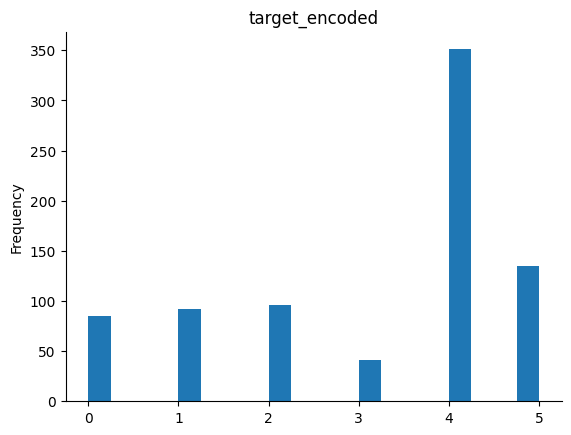

In [26]:
filtered_df_split['target_encoded'].plot(kind='hist', bins=20, title='target_encoded') # df_split
plt.gca().spines[['top', 'right',]].set_visible(False)

### train-test-split

In [29]:
# changes were made for smaller array for smaller array
X = filtered_df_split.drop('target_encoded', axis=1) # df_split
y = filtered_df_split['target_encoded'] # df_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((640, 1), (160, 1), (640,), (160,))

In [30]:
# changes were made for smaller array for smaller array
train_dataframes = {spectrogram_id: random_dataframes_subset[spectrogram_id] for spectrogram_id in X_train['spectrogram_id']} # dataframes
test_dataframes = {spectrogram_id: random_dataframes_subset[spectrogram_id] for spectrogram_id in X_test['spectrogram_id']} # dataframes

In [31]:
len(train_dataframes.keys()),len(test_dataframes.keys())

(640, 160)

### Preprocessing

In [34]:
def impute_with_mean(df):
    """Impute missing values with the mean of the column."""
    return df.fillna(df.mean())

In [35]:
# if impute with zeros
# def impute_with_zero(df):
#     """Impute missing values with 0."""
#     return df.fillna(0)

In [36]:
def flatten_dataframe(df):
    """Flatten the DataFrame to a 1D array."""
    return df.values.flatten()

In [39]:
def process_dataframes_with_tqdm(dataframes_dict, impute_func):
    """Process the given dictionary of dataframes with the specified imputation function and flatten them, with progress indicated by tqdm."""
    processed_data = {}
    for spectrogram_id, df in tqdm(dataframes_dict.items(), desc="Processing DataFrames"):
        # Impute missing values
        imputed_df = impute_func(df)
        # Flatten the DataFrame to a 1D array
        flattened_array = flatten_dataframe(imputed_df)
        # Store the flattened array in the dictionary
        processed_data[spectrogram_id] = flattened_array
    return processed_data

# Apply the processing to train_dataframes and test_dataframes
train_data_processed = process_dataframes_with_tqdm(train_dataframes, impute_with_mean)
test_data_processed = process_dataframes_with_tqdm(test_dataframes, impute_with_mean)

Processing DataFrames: 100%|██████████| 160/160 [00:24<00:00,  6.64it/s]


In [42]:
len(train_data_processed.keys()),len(test_data_processed.keys())

(640, 160)

In [45]:
list_order_X_train = list(X_train['spectrogram_id']) # if bug occur list_order_X_train = list(X_train) 
list_order_X_test = list(X_test['spectrogram_id']) # if bug occur # list_order_X_test = list(X_test)

In [46]:
def convert_dict_to_dataframe(processed_data, order=None):
    """Converts processed data dictionary to a DataFrame and optionally orders the DataFrame based on the given order list."""
    data_list = [(k, v) for k, v in processed_data.items()]

    if order is not None:
        data_list = sorted(data_list, key=lambda x: order.index(x[0]))

    processed_df = pd.DataFrame(data_list, columns=['spectrogram_id', 'flattened_array'])
    flattened_df = pd.DataFrame(processed_df['flattened_array'].tolist())
    flattened_df['spectrogram_id'] = processed_df['spectrogram_id']

    return flattened_df

train_data_df = convert_dict_to_dataframe(train_data_processed, order=list_order_X_train)
test_data_df = convert_dict_to_dataframe(test_data_processed, order=list_order_X_test)

In [ ]:
# del train_data_processed, 
# del test_data_processed
# gc.collect()

In [48]:
train_data_df.shape

(640, 120001)

In [51]:
train_data_features = train_data_df.drop('spectrogram_id', axis=1)
test_data_features = test_data_df.drop('spectrogram_id', axis=1)

Accuracy with random forest all components: 0.5875
Classification Report with random forest all components:
               precision    recall  f1-score   support

           0       0.64      0.50      0.56        18
           1       0.00      0.00      0.00        12
           2       0.50      0.12      0.19        17
           3       0.00      0.00      0.00         8
           4       0.61      0.86      0.71        80
           5       0.54      0.56      0.55        25

    accuracy                           0.59       160
   macro avg       0.38      0.34      0.34       160
weighted avg       0.51      0.59      0.52       160



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))



Log Loss with random forest all components: 1.2522791827580302



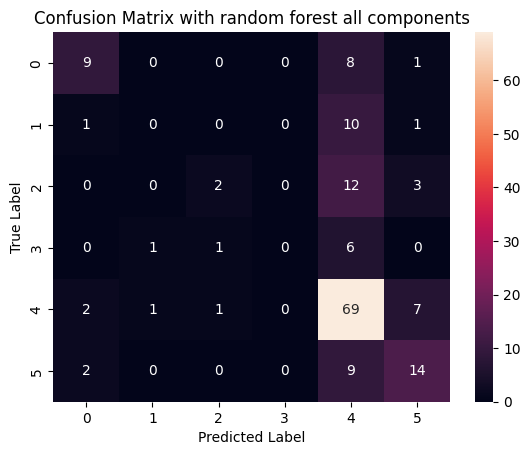

In [52]:
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier.fit(train_data_features, y_train)
y_pred = rf_classifier.predict(test_data_features)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy with random forest all components: {accuracy}")

report = classification_report(y_test, y_pred)
print("Classification Report with random forest all components:\n", report)

y_probs = rf_classifier.predict_proba(test_data_features)
logloss = log_loss(y_test, y_probs)
print(f"\nLog Loss with random forest all components: {logloss}\n")

conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix with random forest all components")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

#### crushing the program (XGBoost without PCA)

In [ ]:
# xgb_classifier_pca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

# xgb_classifier_pca.fit(train_data_features, y_train)

# y_pred = xgb_classifier_pca.predict(test_data_features)

# accuracy_pca = accuracy_score(y_test, y_pred)
# print(f"Accuracy with XGBoost  all components: {accuracy_pca}")

# report_pca = classification_report(y_test, y_pred)
# print("Classification Report with XGBoost  all components:\n", report_pca)

# y_probs = xgb_classifier_pca.predict_proba(test_data_features)

# logloss = log_loss(y_test, y_probs)
# print(f"Log Loss with XGBoost  all components: {logloss}")

# conf_matrix = confusion_matrix(y_test, y_pred)
# sns.heatmap(conf_matrix, annot=True, fmt="d")
# plt.title("Confusion Matrix with XGBoost  all components")
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.show()

### pca

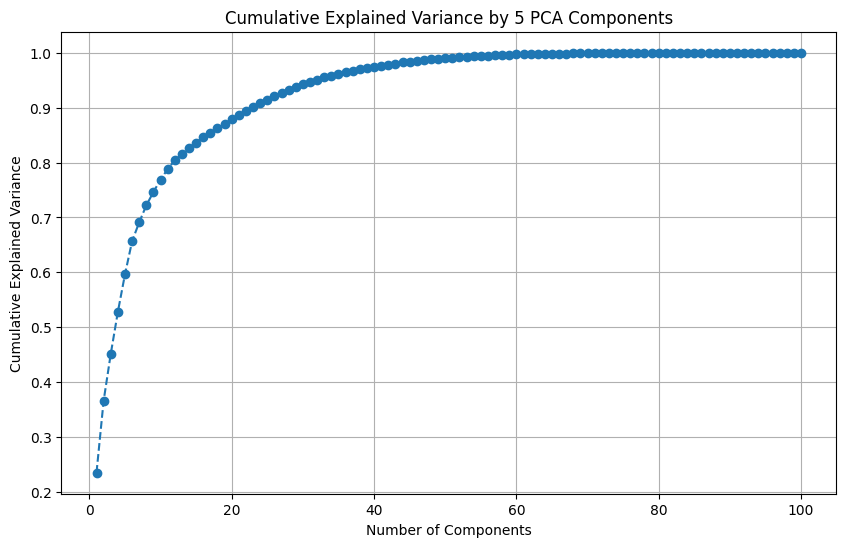

Explained variance ratio per component:
Component 1: 23.5160%
Component 2: 13.0887%
Component 3: 8.5303%
Component 4: 7.6593%
Component 5: 6.8445%
Component 6: 6.0326%
Component 7: 3.4436%
Component 8: 3.0924%
Component 9: 2.4263%
Component 10: 2.2760%
Component 11: 1.8769%
Component 12: 1.6150%
Component 13: 1.1931%
Component 14: 1.0574%
Component 15: 0.9944%
Component 16: 0.9251%
Component 17: 0.8698%
Component 18: 0.8157%
Component 19: 0.8038%
Component 20: 0.7934%
Component 21: 0.7767%
Component 22: 0.7336%
Component 23: 0.7265%
Component 24: 0.7069%
Component 25: 0.6674%
Component 26: 0.6649%
Component 27: 0.5483%
Component 28: 0.5472%
Component 29: 0.5308%
Component 30: 0.5159%
Component 31: 0.4413%
Component 32: 0.4052%
Component 33: 0.3810%
Component 34: 0.3416%
Component 35: 0.2951%
Component 36: 0.2803%
Component 37: 0.2769%
Component 38: 0.2535%
Component 39: 0.2326%
Component 40: 0.2272%
Component 41: 0.2115%
Component 42: 0.2055%
Component 43: 0.2010%
Component 44: 0.1999%

In [54]:
# visualise only 100  copmponents

from sklearn.decomposition import PCA
n_components = 100

pca = PCA(n_components=n_components)
pca.fit(train_data_features)
pca_components = pca.transform(train_data_features)

explained_variance_ratio = pca.explained_variance_ratio_

cumulative_explained_variance = np.cumsum(explained_variance_ratio)

plt.figure(figsize=(10, 6))
plt.plot(range(1, n_components + 1), cumulative_explained_variance, marker='o', linestyle='--')
plt.title('Cumulative Explained Variance by 100 PCA Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.grid(True)
plt.show()

print("Explained variance ratio per component:")
for i, variance in enumerate(explained_variance_ratio, start=1):
    variance_in_percentage = variance * 100
    print(f"Component {i}: {variance_in_percentage:.4f}%")
cumulative_explained_variance *= 100
print(f"\nCumulative explained variance by {n_components} components: {cumulative_explained_variance[-1]:.4f}%")

In [55]:
top_components = 40
print(f"Cumulative explained variance of top {top_components} components: {cumulative_explained_variance[top_components - 1]:.4f}%")


Cumulative explained variance of top 40 components: 97.4072%


In [56]:
pca_train_components = pca.transform(train_data_features)[:, :top_components]
pca_test_components = pca.transform(test_data_features)[:, :top_components]
X_train_selected_pca = pca_train_components
X_test_selected_pca = pca_test_components

In [57]:
test_data_features.shape

(160, 120000)

In [58]:
X_train_selected_pca.shape,X_test_selected_pca.shape

((640, 40), (160, 40))

Accuracy with PCA RandomForest components: 0.5375
Classification Report with PCA RandomForest components:
               precision    recall  f1-score   support

           0       0.43      0.33      0.38        18
           1       0.25      0.08      0.12        12
           2       0.62      0.29      0.40        17
           3       0.00      0.00      0.00         8
           4       0.56      0.91      0.70        80
           5       0.25      0.04      0.07        25

    accuracy                           0.54       160
   macro avg       0.35      0.28      0.28       160
weighted avg       0.45      0.54      0.45       160

Log Loss with randomforest PCA  components: 1.4059565046404496


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


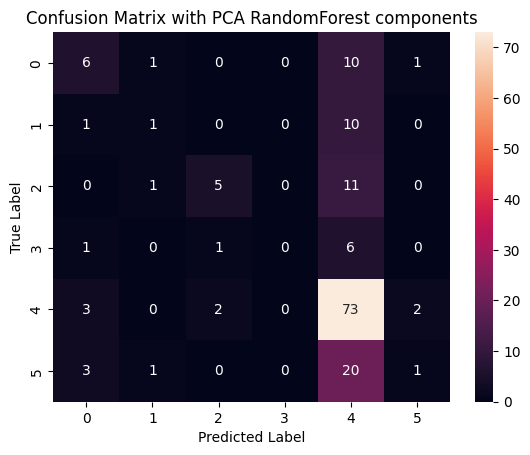

In [59]:
rf_classifier_pca = RandomForestClassifier(n_estimators=100, random_state=42)
rf_classifier_pca.fit(X_train_selected_pca, y_train)
y_pred_pca = rf_classifier_pca.predict(X_test_selected_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA RandomForest components: {accuracy_pca}")

report_pca = classification_report(y_test, y_pred_pca)
print("Classification Report with PCA RandomForest components:\n", report_pca)

y_probs_pca = rf_classifier_pca.predict_proba(X_test_selected_pca)

logloss_pca = log_loss(y_test, y_probs_pca)
print(f"Log Loss with randomforest PCA  components: {logloss_pca}")

conf_matrix = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix with PCA RandomForest components")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

Accuracy with PCA XGBoost components: 0.4375
Classification Report with PCA XGBoost components:
               precision    recall  f1-score   support

           0       0.35      0.33      0.34        18
           1       0.27      0.25      0.26        12
           2       0.17      0.12      0.14        17
           3       0.00      0.00      0.00         8
           4       0.57      0.70      0.63        80
           5       0.17      0.12      0.14        25

    accuracy                           0.44       160
   macro avg       0.25      0.25      0.25       160
weighted avg       0.39      0.44      0.41       160

Log Loss with XGBoost  PCA components: 1.950825586102026


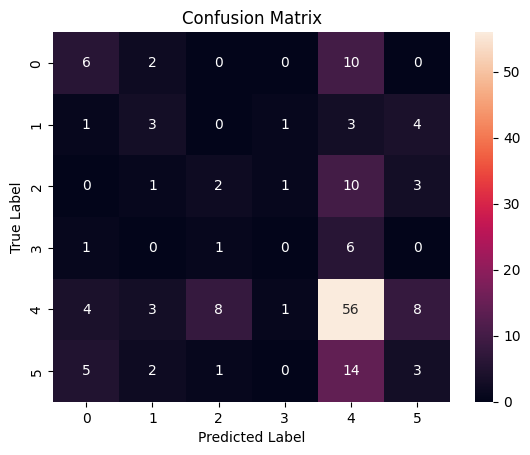

In [60]:
xgb_classifier_pca = XGBClassifier(n_estimators=100, random_state=42, use_label_encoder=False, eval_metric='mlogloss')

xgb_classifier_pca.fit(X_train_selected_pca, y_train)

y_pred_pca = xgb_classifier_pca.predict(X_test_selected_pca)

accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f"Accuracy with PCA XGBoost components: {accuracy_pca}")

report_pca = classification_report(y_test, y_pred_pca)
print("Classification Report with PCA XGBoost components:\n", report_pca)

y_probs_pca = xgb_classifier_pca.predict_proba(X_test_selected_pca)

logloss_pca = log_loss(y_test, y_probs_pca)
print(f"Log Loss with XGBoost  PCA components: {logloss_pca}")

conf_matrix = confusion_matrix(y_test, y_pred_pca)
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


### current problems:
 - too many smaples crush the program.
 - XGBoost without PCA crush the program.
 - doing sample which are sub_spectogram_id == 0 weren't tried here, at former runs they were better, furhter adjustment to
   load_spectrograms is necessary for that.
 - maybe combining  the functions: process_dataframes_with_tqdm  & convert_dict_to_dataframe  will make the program ligher.    and less memory problems.
 - the entire dataset is 106800 (different spectpgrams) X 300 (rows) X 400(cols)...other processing solution is required